In [1]:
from tms_risk.utils.data import get_all_behavior
import seaborn as sns
import pingouin
import matplotlib.pyplot as plt
import os.path as op
import pandas as pd
import numpy as np
from tms_risk.cogmodels.fit_probit import build_model, get_data
import arviz as az
from tms_risk.cogmodels.utils import stimulation_palette, stimulation_order
from tms_risk.cogmodels.utils import extract_intercept_gamma, format_bambi_ppc, plot_ppc

bids_folder = '/data/ds-tmsrisk'


plt.rcParams['font.family'] = 'sans-serif'

In [2]:
model_label = 'probit_order'
data = get_data(model_label, bids_folder)
model = build_model(model_label, data)

idata = az.from_netcdf(op.join(bids_folder, 'derivatives', 'cogmodels', f'model-{model_label}_trace.netcdf'))

Dropping the baseline condition


In [3]:
data['Order'] = data['risky_first'].map({True: 'Risky first', False: 'Risky second'})

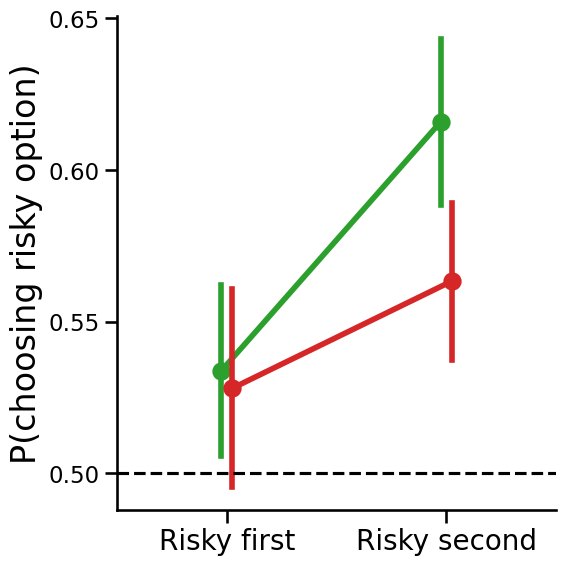

In [4]:
# sns.set_context('poster')
# g._legend.set_title('Stimulation condition')
tmp = data.groupby(['subject', 'Order', 'stimulation_condition'])['chose_risky'].mean()

# Scale font size by 1.5
sns.set_context('talk', font_scale=1.)


g = sns.catplot(x='Order', y='chose_risky', hue='stimulation_condition', data=tmp.reset_index(), kind='point', dodge=True, palette=stimulation_palette, order=['Risky first', 'Risky second'], legend=False,
                errorbar='se',
                height=6.)

g.set_axis_labels('', '')

plt.ylabel('P(choosing risky option)', size=24)

# Set xticks to be only .5, .55, .6, and .65
_ =g.ax.set_yticks(np.arange(.5, .65, .05))

# Set size of xticks
g.ax.tick_params(axis='x', labelsize=20)

plt.axhline(0.5, c='k', ls='--')
# Set size figure
g.fig.set_size_inches(6, 6)
plt.tight_layout()

g.set_titles(' ')
plt.savefig('/Users/gdehol/Dropbox/Science/TMS_Risk/figures/figure2a.pdf', dpi=300, bbox_inches='tight')

In [5]:
ppc = format_bambi_ppc(idata.sel(draw=slice(None, None, 10)), model, data)

In [6]:
from tms_risk.cogmodels.utils import cluster_offers, summarize_ppc

def plot_ppc(df, ppc, plot_type=1, var_name='ll_bernoulli', level='subject', col_wrap=5, legend=True, **kwargs):

    assert (var_name in ['p', 'll_bernoulli'])

    ppc = ppc.xs(var_name, 0, 'variable').copy()

    df = df.copy()

    # Make sure that we group data from (Roughly) same fractions
    if not (df.groupby(['subject', 'log(risky/safe)']).size().groupby('subject').size() < 7).all():
        df['log(risky/safe)'] = df.groupby(['subject'],
                                        group_keys=False).apply(cluster_offers)
        # df = df.set_index('log(risky/safe)', append=True)

    if level == 'group':
        df['log(risky/safe)'] = df['bin(risky/safe)']
        ppc.reset_index('log(risky/safe)', drop=True, inplace=True)
        # ppc.set_index(df['log(risky/safe)'], append=True, inplace=True)
        ppc['log(risky/safe)'] = ppc.index.get_level_values('bin(risky/safe)')
        ppc.set_index('log(risky/safe)', append=True, inplace=True)

    if plot_type == 0:
        groupby = ['log(risky/safe)', 'stimulation_condition']
    elif plot_type == 1:
        groupby = ['risky_first', 'log(risky/safe)']
    elif plot_type in [2, 4]:
        groupby = ['risky_first', 'n_safe']
    elif plot_type in [3, 5]:
        groupby = ['risky_first', 'n_safe', 'log(risky/safe)']
    elif plot_type in [6]:
        groupby = ['risky_first', 'n_safe', 'stimulation_condition']
    elif plot_type in [7]:
        groupby = ['risky_first', 'log(risky/safe)', 'stimulation_condition']
    elif plot_type in [8, 9]:
        groupby = ['risky_first', 'log(risky/safe)', 'stimulation_condition', 'n_safe']
    else:
        raise NotImplementedError

    if level == 'group':
        ppc = ppc.groupby(['subject']+groupby).mean()

    if level == 'subject':
        groupby = ['subject'] + groupby

    ppc_summary = summarize_ppc(ppc, groupby=groupby)
    p = df.groupby(groupby)[['chose_risky']].mean()
    ppc_summary = ppc_summary.join(p).reset_index()

    if 'risky_first' in ppc_summary.columns:
        ppc_summary['Order'] = ppc_summary['risky_first'].map({True:'Risky first', False:'Risky second'})

    if 'n_safe' in groupby:
        ppc_summary['Safe offer'] = ppc_summary['n_safe'].astype(int)

    ppc_summary['Prop. chosen risky'] = ppc_summary['chose_risky']

    if 'log(risky/safe)' in groupby:
        if level == 'group':
            ppc_summary['Predicted acceptance'] = ppc_summary['log(risky/safe)']
        else:
            ppc_summary['Log-ratio offer'] = ppc_summary['log(risky/safe)']

    if plot_type in [2, 6]:
        x = 'Safe offer'
    else:
        if level == 'group':
            x = 'Predicted acceptance'
        else:
            x = 'Log-ratio offer'


    if plot_type in [0]:
        fac = sns.FacetGrid(ppc_summary,
                            col='subject' if level == 'subject' else None,
                            hue='stimulation_condition',
                            col_wrap=col_wrap if level == 'subject' else None,
                            hue_order=['vertex', 'ips'],
                            palette=sns.color_palette()[2:],
                            **kwargs)


    elif plot_type in [1, 2]:
        fac = sns.FacetGrid(ppc_summary,
                            col='subject' if level == 'subject' else None,
                            hue='Order',
                            col_wrap=col_wrap if level == 'subject' else None,
                            **kwargs)

    elif plot_type == 3:
        fac = sns.FacetGrid(ppc_summary,
                            col='Safe offer',
                            hue='Order',
                            row='subject' if level == 'subject' else None,
                            **kwargs)
    elif plot_type == 4:


        if level == 'group':
            rnp = df.groupby(['subject'] + groupby, group_keys=False).apply(get_rnp).to_frame('rnp')
            rnp = rnp.groupby(groupby).mean()
        else:
            rnp = df.groupby(groupby, group_keys=False).apply(get_rnp).to_frame('rnp')

        ppc_summary = ppc_summary.join(rnp)
        fac = sns.FacetGrid(ppc_summary,
                            hue='Order',
                            col='subject' if level == 'subject' else None,
                            col_wrap=col_wrap if level == 'subject' else None,
                            **kwargs)

        fac.map_dataframe(plot_prediction, x='Safe offer', y='p_predicted')
        fac.map(plt.scatter, 'Safe offer', 'rnp')
        fac.map(lambda *args, **kwargs: plt.axhline(.55, c='k', ls='--'))

    elif plot_type == 5:
        fac = sns.FacetGrid(ppc_summary,
                            col='Order',
                            hue='Safe offer',
                            row='subject' if level == 'subject' else None,
                            palette='coolwarm',
                            **kwargs)

    elif plot_type == 6:
        fac = sns.FacetGrid(ppc_summary,
                            col='Order',
                            hue='stimulation_condition',
                            hue_order=['vertex', 'ips'],
                            row='subject' if level == 'subject' else None,
                            palette=sns.color_palette()[2:],
                            **kwargs)

    elif plot_type == 7:
        fac = sns.FacetGrid(ppc_summary,
                            row='Order',
                            hue='stimulation_condition',
                            hue_order=['vertex', 'ips'],
                            palette=stimulation_palette,
                            height=5.,
                            aspect=1.,
                            row_order = ['Risky first', 'Risky second'],
                            **kwargs)


    elif plot_type == 8:
        if level == 'subject':
            raise NotImplementedError

        fac = sns.FacetGrid(ppc_summary,
                            col='Order',
                            hue='Safe offer',
                            row='stimulation_condition',
                            hue_order=['vertex', 'ips'],
                            palette='coolwarm',
                            **kwargs)

    elif plot_type == 9:
        if level == 'subject':
            raise NotImplementedError

        fac = sns.FacetGrid(ppc_summary,
                            col='Order',
                            hue='stimulation_condition',
                            hue_order=['vertex', 'ips'],
                            row='Safe offer',
                            palette=sns.color_palette()[2:],
                            **kwargs)


    if plot_type in [0, 1,2,3, 5, 6, 7, 8, 9]:
        fac.map_dataframe(plot_prediction, x=x)
        fac.map(plt.scatter, x, 'Prop. chosen risky')
        fac.map(lambda *args, **kwargs: plt.axhline(.5, c='k', ls='--'))

    if plot_type in [0, 1, 3, 5, 7, 9]:
        if level == 'subject':
            fac.map(lambda *args, **kwargs: plt.axvline(np.log(1./.55), c='k', ls='--'))
        else:
            fac.map(lambda *args, **kwargs: plt.axvline(2.5, c='k', ls='--'))

    
    if legend:
        fac.add_legend()

    # fac.set_titles('{col_name}')
    # fac.set_xlabels('Risky/safe ratio (6 bins)', size=16)

    return fac

def plot_prediction(data, x, color, y='p_predicted', alpha=.5, **kwargs):
    data = data[~data['hdi025'].isnull()]

    plt.fill_between(data[x], data['hdi025'],
                     data['hdi975'], color=color, alpha=alpha)
    plt.plot(data[x], data[y], color=color)


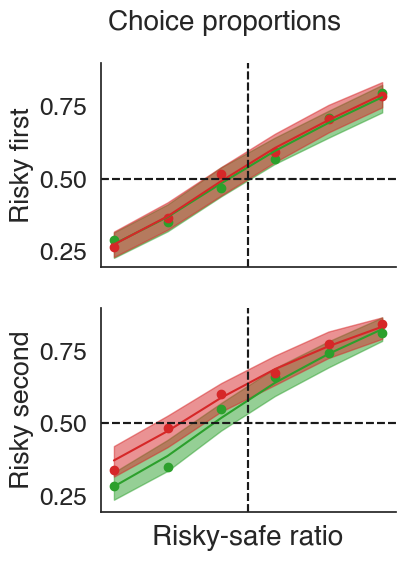

In [7]:
sns.set(font_scale=1.6, font='Helvetica', style='white',)
# sns.set_palette("colorblind")
g = plot_ppc(data, ppc, 7, level='group', var_name='ll_bernoulli', legend=False)

g.fig.set_size_inches(4., 6.)

# g.set(xticks=[], yticks=[.25, .5, .75])
g.set(xticks=[2.5], xlabel=None)
g.set_xticklabels(['Risky-safe ratio'], size=20)
# Set the size of the col titles slightly larger
g.set_titles('', size=24)
g.fig.suptitle('Choice proportions', y=.95, size=20)
g.set_ylabels('')
plt.tight_layout()

g.axes[0, 0].set_yticks([.25, .5, .75])
g.axes[0, 0].set_ylabel('Risky first')
g.axes[1, 0].set_ylabel('Risky second')

plt.savefig('/Users/gdehol/Dropbox/Science/TMS_Risk/figures/figure2b.pdf', dpi=300, bbox_inches='tight')

In [8]:
intercept, gamma = extract_intercept_gamma(idata, model, data, group=True)
intercept = intercept.stack([1, 2])['intercept']
gamma = gamma.stack([1, 2])['gamma']

rnp = np.clip(np.exp(intercept/gamma),0, 1).rename('rnp')

/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_49479/2162837653.py:2: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  intercept = intercept.stack([1, 2])['intercept']
/var/folders/d4/cpqhwlbn301clph1qk64k01nmjkty3/T/ipykernel_49479/2162837653.py:3: FutureWarning: The previous implementation of stack is deprecated and will be removed in a future version of pandas. See the What's New notes for pandas 2.1.0 for details. Specify future_stack=True to adopt the new implementation and silence this warning.
  gamma = gamma.stack([1, 2])['gamma']


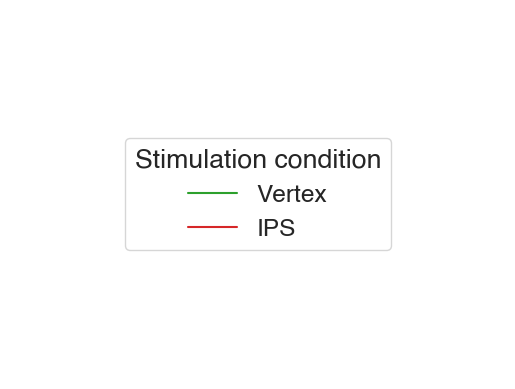

In [10]:
# Plot a legend figure
fig, ax = plt.subplots()
for ix, label in enumerate(stimulation_order):
    ax.plot([], [], label=label, color=stimulation_palette[ix])
ax.legend(title='Stimulation condition', loc='center', frameon=True)
ax.axis('off')

# Make sure that white background is not saved as transparent
plt.gca().patch.set_facecolor('white')
plt.gca().patch.set_alpha(1.)

plt.savefig('/Users/gdehol/Dropbox/Science/TMS_Risk/figures/figure2_legend.pdf', dpi=300, bbox_inches='tight', transparent=True)

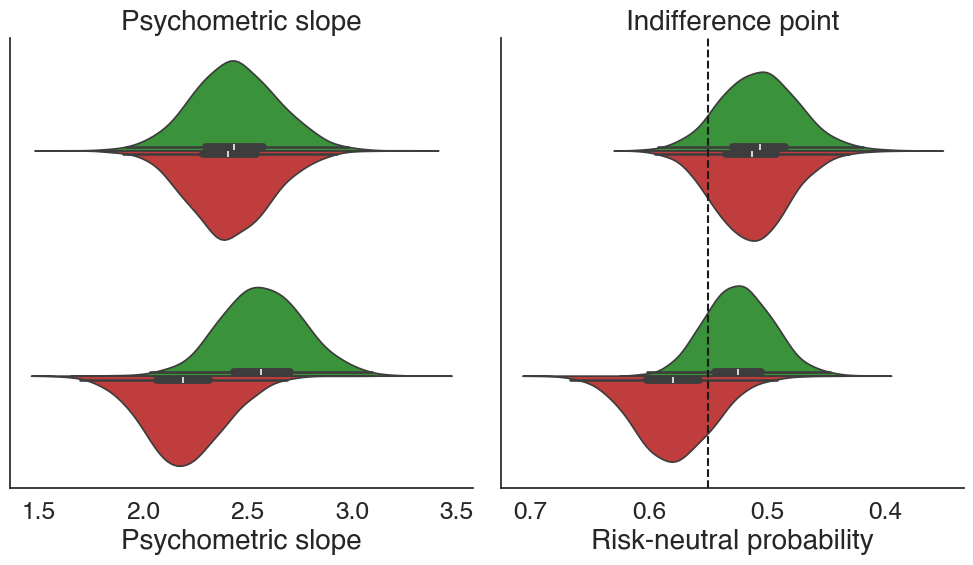

In [11]:
pars = pd.concat((gamma, rnp), axis=1, keys=['gamma', 'rnp'], names=['parameter'])

pars = pars.stack().to_frame('value')

pars['Order'] = pars.index.get_level_values('risky_first').map({True: 'Risky first', False: 'Risky second'})

# sns.catplot(x='')
g = sns.FacetGrid(pars.reset_index(), col='parameter', sharey=True, sharex=False, palette=stimulation_palette, height=6., aspect=1.)

# g.map_dataframe(sns.kdeplot, x='value', fill=True, bw_method=.5)
g.map_dataframe(sns.violinplot, y='Order', x='value', hue='stimulation_condition', palette=stimulation_palette, split=True, bw_adjust=2.5,
                order=['Risky first', 'Risky second'])

g.set_axis_labels('', '', size=24)
g.set_ylabels('')
g.set_yticklabels('')


# g.set_titles('{row_name}')

# Set the two panel titles to Gamma and RNP

g.axes[0, 0].set_title('Psychometric slope', size=20)
g.axes[0, 0].set_xlabel('Psychometric slope', size=20)
g.axes[0, 1].set_title('Indifference point', size=20)
g.axes[0, 1].axvline(0.55, c='k' ,ls='--')
g.axes[0, 1].invert_xaxis()
g.axes[0, 1].set_xlabel('Risk-neutral probability', size=20)




plt.savefig('/Users/gdehol/Dropbox/Science/TMS_Risk/figures/figure2c.pdf', dpi=300, bbox_inches='tight')

In [ ]:
rn

In [17]:
import arviz as az
display(rnp.groupby(['stimulation_condition', 'risky_first']).mean())

rnp.groupby(['stimulation_condition', 'risky_first']).apply(lambda x: pd.Series(az.hdi(x.values , hdi_prob=.95)))

stimulation_condition  risky_first
ips                    False          0.579125
                       True           0.513108
vertex                 False          0.523990
                       True           0.506348
Name: rnp, dtype: float64

stimulation_condition  risky_first   
ips                    False        0    0.518259
                                    1    0.643734
                       True         0    0.452933
                                    1    0.571142
vertex                 False        0    0.472021
                                    1    0.583499
                       True         0    0.443915
                                    1    0.573674
Name: rnp, dtype: float64

In [18]:
import arviz as az
display(gamma.groupby(['stimulation_condition', 'risky_first']).mean())

gamma.groupby(['stimulation_condition', 'risky_first']).apply(lambda x: pd.Series(az.hdi(x.values , hdi_prob=.95)))

stimulation_condition  risky_first
ips                    False          2.194227
                       True           2.414012
vertex                 False          2.568795
                       True           2.439123
Name: gamma, dtype: float64

stimulation_condition  risky_first   
ips                    False        0    1.829392
                                    1    2.559883
                       True         0    2.069855
                                    1    2.820289
vertex                 False        0    2.185591
                                    1    2.966590
                       True         0    2.050767
                                    1    2.849891
Name: gamma, dtype: float64